In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from numpy import savez_compressed, load

%matplotlib inline

In [4]:
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback

## **Setting the data directories and loading types of crop diseases**

In [ ]:
data_path='/content/drive/My Drive/Colab_Files/Crop_disease/Dataset'
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
print(f'Total {len(disease_types)} types of diseases to be identified.')

Total 15 types of diseases to be identified.


### **Reading training data to pandas dataframe**

In [ ]:
train_data = []
for d_id, name in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_path,name)):
        train_data.append(['{}/{}'.format(name,file), d_id, name])

train = pd.DataFrame(train_data, columns = ['file', 'disease_id', 'disease_name'])
train.head()
## total files = 20639
## image size = 64 x 64 x3

,file,disease_id,disease_name
0,Pepper__bell___Bacterial_spot/131dd897-98e3-45...,0,Pepper__bell___Bacterial_spot
1,Pepper__bell___Bacterial_spot/e2baac0d-0b5c-4e...,0,Pepper__bell___Bacterial_spot
2,Pepper__bell___Bacterial_spot/d2b4564a-7428-4f...,0,Pepper__bell___Bacterial_spot
3,Pepper__bell___Bacterial_spot/9f36da2c-ab51-4f...,0,Pepper__bell___Bacterial_spot
4,Pepper__bell___Bacterial_spot/f92689ca-b5db-4a...,0,Pepper__bell___Bacterial_spot


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20639 entries, 0 to 20638
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file          20639 non-null  object
 1   disease_id    20639 non-null  int64 
 2   disease_name  20639 non-null  object
dtypes: int64(1), object(2)
memory usage: 483.9+ KB


In [ ]:
defect_files=train['file'][train['disease_name']=='Pepper__bell___Bacterial_spot'].values
# defect_files=train['file'][train['disease_name']=='Tomato_Bacterial_spot'].values

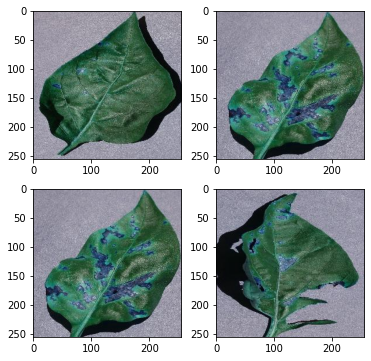

In [ ]:
#function takes in disease type and plots nrows*ncols images for it
def plot_leaves(disease_type,nrows,ncols):
    fig, ax = plt.subplots(nrows,ncols, figsize = (6,6))
    def_files = train['file'][train['disease_name'] == disease_type].values
    
    for i in range(nrows):
        for j in range(ncols):
            ax[i,j].imshow(cv2.imread(os.path.join(data_path, def_files[i+j])))
plot_leaves('Pepper__bell___Bacterial_spot',2,2)

In [ ]:
train_1 = train.sample(frac = 1.0, random_state = 42)
train_1.reset_index(inplace = True,drop=True)
train_1.head()

,file,disease_id,disease_name
0,Tomato_healthy/7a51866d-a48a-4443-8243-b7de561...,14,Tomato_healthy
1,Potato___Early_blight/45ecd7ac-7db9-49bf-b34d-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot/45c3dbbf-94eb-4e9e-9...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/b427ec05-0b9a-45c6-8148-cbddad6...,14,Tomato_healthy
4,Tomato_Leaf_Mold/6337ca93-b6c5-439e-964b-9ad0b...,8,Tomato_Leaf_Mold


### **Visualizing data**

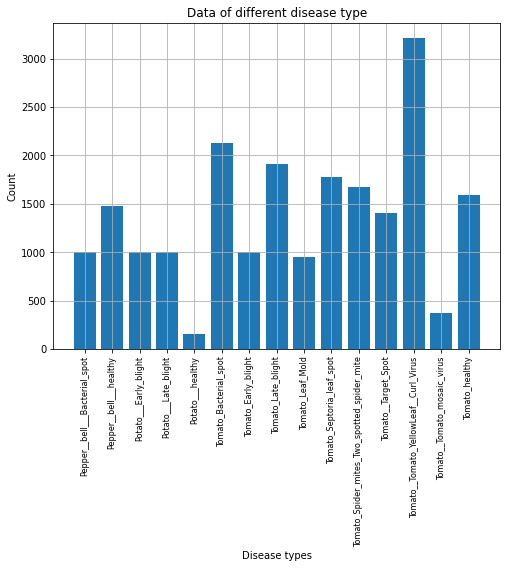

In [ ]:
# train_1.groupby('disease_id').count()
plt.figure(figsize=(8, 6))
# plt.hist(train.disease_id,bins = 15)
df1 = train.groupby('disease_id').count()
xticks = disease_types
plt.bar(xticks, df1['disease_name'])
plt.xticks(xticks,rotation = 90, size=8)
plt.xlabel('Disease types')
plt.ylabel('Count')
plt.grid()
plt.title('Data of different disease type')
plt.show()

In [ ]:
#function to read image and resize using opncv
def read_image(filepath):
    image = cv2.imread(os.path.join(data_path,filepath))
    return image
def resize_image(image,size):
    return cv2.resize(image.copy(), size, interpolation = cv2.INTER_AREA)

In [ ]:
# from tqdm import tqdm
# image_size = 64
# X_data = np.zeros((train_1.shape[0],image_size,image_size,3))
# for i, file in tqdm(enumerate(train_1['file'].values)):
#     image = read_image(file)
#     if image is not None:
#         X_data[i]=resize_image(image,(image_size,image_size))
#     #print (i)
#     #print (file)
# X_data=X_data/255.
# print ('Data shape = {}'.format(X_data.shape))

20639it [1:10:21,  4.89it/s]


Data shape = (20639, 64, 64, 3)


In [ ]:
# y_data=train_1['disease_id'].values
# print (y_data.shape)
# y_data= tf.keras.utils.to_categorical(y_data,num_classes=15)
# print (y_data.shape)

(20639,)
(20639, 15)


In [5]:
X_data = load('/content/drive/MyDrive/X_data.npy')

In [6]:
y_data = load('/content/drive/MyDrive/y_data.npy')

In [7]:
SEED = 42
X_train1, X_test, Y_train1, Y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train1, Y_train1, test_size=0.2, random_state=SEED)

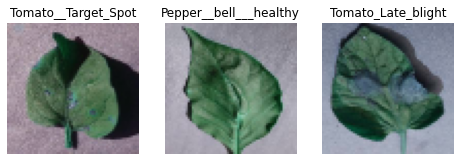

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

## **1.Simple Artificial neural network with fully connected layers**



In [ ]:
from time import time
model_1=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (64,64,3)),
    tf.keras.layers.Dense(256, activation='relu',kernel_initializer='HeNormal'),
    tf.keras.layers.Dense(128, activation='relu',kernel_initializer='HeNormal'),
    tf.keras.layers.Dense(15, activation='softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model_1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
t0 = time()
history = model_1.fit(X_train,Y_train, validation_data=(X_val, Y_val),epochs=100)
print ("training time: ", round(time()-t0, 3), "s")
model_1.evaluate(X_val,Y_val)

###


Epoch 1/100
413/413 [==============================] - 9s 19ms/step - loss: 2.2144 - accuracy: 0.2844 - val_loss: 1.8807 - val_accuracy: 0.3848
Epoch 2/100
413/413 [==============================] - 8s 19ms/step - loss: 1.7693 - accuracy: 0.4286 - val_loss: 1.5945 - val_accuracy: 0.4992
Epoch 3/100
413/413 [==============================] - 8s 19ms/step - loss: 1.5503 - accuracy: 0.5034 - val_loss: 1.5117 - val_accuracy: 0.5071
Epoch 4/100
413/413 [==============================] - 8s 19ms/step - loss: 1.4361 - accuracy: 0.5366 - val_loss: 1.4341 - val_accuracy: 0.5265
Epoch 5/100
413/413 [==============================] - 8s 19ms/step - loss: 1.3241 - accuracy: 0.5759 - val_loss: 1.2988 - val_accuracy: 0.5807
Epoch 6/100
413/413 [==============================] - 8s 19ms/step - loss: 1.2449 - accuracy: 0.5963 - val_loss: 1.3082 - val_accuracy: 0.5737
Epoch 7/100
413/413 [==============================] - 8s 19ms/step - loss: 1.1779 - accuracy: 0.6214 - val_loss: 1.1081 - val_accuracy:

[0.7724828124046326, 0.7895852327346802]

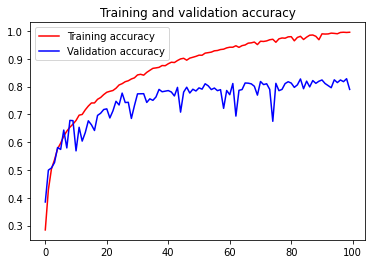

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
#Add some regularizarion like batchnorm and dropout
#Normal neural network (without CNN)
from tensorflow.keras import regularizers
model_1_reg=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (64,64,3)),
    tf.keras.layers.Dense(256, activation='relu',kernel_initializer='HeNormal',kernel_regularizer=regularizers.l2(1e-2)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu',kernel_initializer='HeNormal'),#kernel_regularizer=regularizers.l2(1e-3)),#
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(15, activation='softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_1_reg.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
t0 = time()
history_1 = model_1_reg.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=30)
print ("training time: ", round(time()-t0, 3), "s")
model_1_reg.evaluate(X_val,Y_val)

Epoch 1/30
413/413 [==============================] - 15s 36ms/step - loss: 3.4537 - accuracy: 0.3284 - val_loss: 2.1840 - val_accuracy: 0.3996
Epoch 2/30
413/413 [==============================] - 15s 35ms/step - loss: 2.0388 - accuracy: 0.4319 - val_loss: 1.9140 - val_accuracy: 0.4620
Epoch 3/30
413/413 [==============================] - 14s 35ms/step - loss: 1.8718 - accuracy: 0.4719 - val_loss: 1.8481 - val_accuracy: 0.4765
Epoch 4/30
413/413 [==============================] - 15s 35ms/step - loss: 1.7818 - accuracy: 0.4994 - val_loss: 1.9277 - val_accuracy: 0.4426
Epoch 5/30
413/413 [==============================] - 15s 35ms/step - loss: 1.7051 - accuracy: 0.5207 - val_loss: 1.9733 - val_accuracy: 0.4750
Epoch 6/30
413/413 [==============================] - 14s 35ms/step - loss: 1.6891 - accuracy: 0.5275 - val_loss: 1.9648 - val_accuracy: 0.4426
Epoch 7/30
413/413 [==============================] - 15s 35ms/step - loss: 1.6306 - accuracy: 0.5478 - val_loss: 1.6469 - val_accuracy:

[1.652220368385315, 0.5389040112495422]

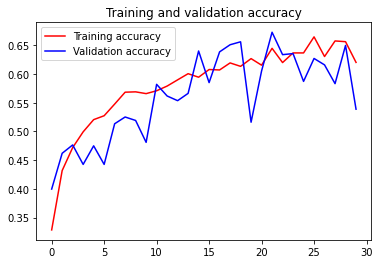

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
#the training slowed down, might need to train for longer for better accuracy in this case

## **2. A simple CNN model**

### v1  3 conv layers | Summary: Train 96%; Val 89%

Epoch 1/20
413/413 [==============================] - 99s 238ms/step - loss: 1.6528 - accuracy: 0.4667 - val_loss: 1.1012 - val_accuracy: 0.6437
Epoch 2/20
413/413 [==============================] - 98s 237ms/step - loss: 0.8726 - accuracy: 0.7109 - val_loss: 0.7446 - val_accuracy: 0.7569
Epoch 3/20
413/413 [==============================] - 98s 237ms/step - loss: 0.6552 - accuracy: 0.7791 - val_loss: 0.5952 - val_accuracy: 0.7944
Epoch 4/20
413/413 [==============================] - 97s 236ms/step - loss: 0.5195 - accuracy: 0.8251 - val_loss: 0.6832 - val_accuracy: 0.7639
Epoch 5/20
413/413 [==============================] - 98s 236ms/step - loss: 0.4547 - accuracy: 0.8450 - val_loss: 0.4867 - val_accuracy: 0.8377
Epoch 6/20
413/413 [==============================] - 97s 236ms/step - loss: 0.3822 - accuracy: 0.8702 - val_loss: 0.4585 - val_accuracy: 0.8438
Epoch 7/20
413/413 [==============================] - 97s 236ms/step - loss: 0.3342 - accuracy: 0.8852 - val_loss: 0.4934 - val_ac

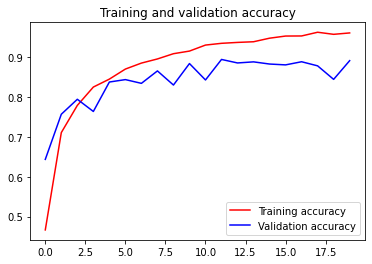

<Figure size 432x288 with 0 Axes>

In [ ]:
## Simple CNN v1
model_2 = tf.keras.Sequential([
    Conv2D(64,(3,3), activation='relu', input_shape = (64,64,3)),
    MaxPool2D(2,2),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])
opt_2 = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=20)

####
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### v2 Batchnormalize | Summary: Train 98%; Val 90%

Epoch 1/20
413/413 [==============================] - 109s 263ms/step - loss: 0.9605 - accuracy: 0.6997 - val_loss: 4.6924 - val_accuracy: 0.1698
Epoch 2/20
413/413 [==============================] - 108s 262ms/step - loss: 0.4796 - accuracy: 0.8461 - val_loss: 0.7148 - val_accuracy: 0.7696
Epoch 3/20
413/413 [==============================] - 108s 262ms/step - loss: 0.3421 - accuracy: 0.8889 - val_loss: 0.7369 - val_accuracy: 0.7693
Epoch 4/20
413/413 [==============================] - 107s 260ms/step - loss: 0.2594 - accuracy: 0.9171 - val_loss: 0.5452 - val_accuracy: 0.8135
Epoch 5/20
413/413 [==============================] - 107s 260ms/step - loss: 0.2035 - accuracy: 0.9334 - val_loss: 0.5617 - val_accuracy: 0.8114
Epoch 6/20
413/413 [==============================] - 106s 257ms/step - loss: 0.1677 - accuracy: 0.9469 - val_loss: 2.7320 - val_accuracy: 0.5126
Epoch 7/20
413/413 [==============================] - 105s 255ms/step - loss: 0.1372 - accuracy: 0.9574 - val_loss: 0.5925 -

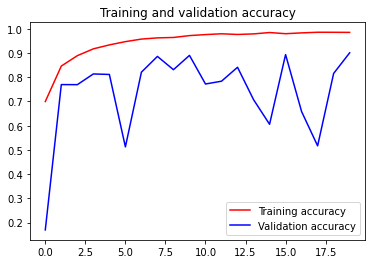

<Figure size 432x288 with 0 Axes>

In [ ]:
## Simple CNN v2
model_2a = tf.keras.Sequential([
    Conv2D(64,(3,3), activation='relu',input_shape = (64,64,3)),
    MaxPool2D(2,2),
    BatchNormalization(),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(15, activation='softmax')
])
opt_2a = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2a.compile(optimizer=opt_2a, loss='categorical_crossentropy', metrics=['accuracy'])
history_2a = model_2a.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=20)

####
acc = history_2a.history['accuracy']
val_acc = history_2a.history['val_accuracy']
loss = history_2a.history['loss']
val_loss = history_2a.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### v3 added conv layers | Summary: Train 93%; Val 88%

Epoch 1/20
413/413 [==============================] - 40s 23ms/step - loss: 1.8969 - accuracy: 0.3949 - val_loss: 1.3044 - val_accuracy: 0.5846
Epoch 2/20
413/413 [==============================] - 9s 21ms/step - loss: 1.0987 - accuracy: 0.6411 - val_loss: 1.0606 - val_accuracy: 0.6418
Epoch 3/20
413/413 [==============================] - 9s 22ms/step - loss: 0.8692 - accuracy: 0.7087 - val_loss: 0.8263 - val_accuracy: 0.7200
Epoch 4/20
413/413 [==============================] - 8s 21ms/step - loss: 0.7202 - accuracy: 0.7555 - val_loss: 0.6982 - val_accuracy: 0.7705
Epoch 5/20
413/413 [==============================] - 8s 20ms/step - loss: 0.6312 - accuracy: 0.7866 - val_loss: 0.6643 - val_accuracy: 0.7878
Epoch 6/20
413/413 [==============================] - 9s 21ms/step - loss: 0.5301 - accuracy: 0.8212 - val_loss: 0.5971 - val_accuracy: 0.7950
Epoch 7/20
413/413 [==============================] - 9s 21ms/step - loss: 0.4858 - accuracy: 0.8349 - val_loss: 0.6862 - val_accuracy: 0.768

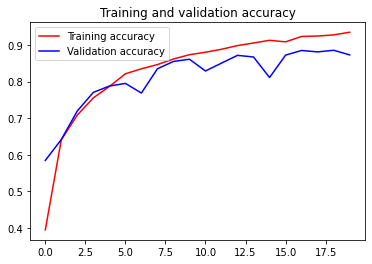

<Figure size 432x288 with 0 Axes>

In [ ]:
## Simple CNN v3
model_2b = tf.keras.Sequential([
    Conv2D(128,(3,3), activation = 'relu', input_shape = (64,64,3)),
    MaxPool2D(2,2),
    Conv2D(64,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])
opt_2b = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2b.compile(optimizer=opt_2b, loss='categorical_crossentropy', metrics=['accuracy'])
history_2b = model_2b.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=20)

####
acc = history_2b.history['accuracy']
val_acc = history_2b.history['val_accuracy']
loss = history_2b.history['loss']
val_loss = history_2b.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### v4 Batch normalize | Summary: Train 97%; Val 92.7%

Epoch 1/20
413/413 [==============================] - 12s 26ms/step - loss: 1.1540 - accuracy: 0.6318 - val_loss: 3.5717 - val_accuracy: 0.1807
Epoch 2/20
413/413 [==============================] - 10s 23ms/step - loss: 0.5883 - accuracy: 0.8024 - val_loss: 2.3018 - val_accuracy: 0.4644
Epoch 3/20
413/413 [==============================] - 10s 23ms/step - loss: 0.4509 - accuracy: 0.8513 - val_loss: 2.3423 - val_accuracy: 0.4708
Epoch 4/20
413/413 [==============================] - 10s 23ms/step - loss: 0.3593 - accuracy: 0.8801 - val_loss: 1.3417 - val_accuracy: 0.6446
Epoch 5/20
413/413 [==============================] - 10s 24ms/step - loss: 0.2874 - accuracy: 0.9020 - val_loss: 1.4803 - val_accuracy: 0.6325
Epoch 6/20
413/413 [==============================] - 9s 23ms/step - loss: 0.2478 - accuracy: 0.9145 - val_loss: 1.5032 - val_accuracy: 0.6452
Epoch 7/20
413/413 [==============================] - 10s 23ms/step - loss: 0.2267 - accuracy: 0.9212 - val_loss: 0.7764 - val_accuracy: 

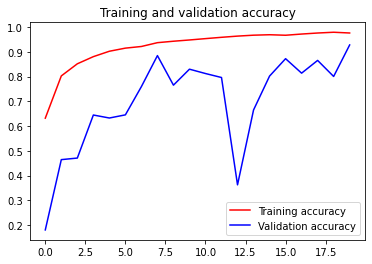

<Figure size 432x288 with 0 Axes>

In [ ]:
## Simple CNN v4
model_2c = tf.keras.Sequential([
    Conv2D(128,(3,3), activation = 'relu', input_shape = (64,64,3)),
    MaxPool2D(2,2),
    BatchNormalization(),
    Conv2D(64,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    # BatchNormalization(),
    Dense(15, activation='softmax')
])
opt_2c = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2c.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_2c = model_2c.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=20)

####
acc = history_2c.history['accuracy']
val_acc = history_2c.history['val_accuracy']
loss = history_2c.history['loss']
val_loss = history_2c.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### v5 regularization | Summary: Train 98%; Val 94%

In [ ]:
## Simple CNN v4
model_2d = tf.keras.Sequential([
    # Conv2D(128,(3,3), activation = 'relu'),
    # MaxPool2D(2,2),
    # BatchNormalization(),
    # Dropout(0.2),
    Conv2D(64,(3,3), activation='relu', input_shape = (64,64,3)),
    MaxPool2D(2,2),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    # BatchNormalization(),
    Dense(15, activation='softmax')
])
opt_2d = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history_2d = model_2d.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=50)

# ####
# acc = history_2d.history['accuracy']
# val_acc = history_2d.history['val_accuracy']
# loss = history_2d.history['loss']
# val_loss = history_2d.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()

# plt.show()

## **2a. Learning rate mods | Summary: Train 98%; Val 93.9%**

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,min_lr=0.001,patience=5,verbose=1)
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab_Files/Crop_disease/model_2_reg.h5',verbose=1,save_best_only=True)
class mycallback(Callback):
    def on_epoch_end(self, epoch, logs= {}):
        if (logs.get('val_accuracy')>0.94):
            print ('\nReached 94% accuracy. So canceling the run')
            self.model.stop_training = True

callbacks=mycallback()
hist_lr = model_2d.fit(X_train, Y_train,
#                steps_per_epoch=X_train.shape[0] // 64,
               epochs=50,
               verbose=2,
               callbacks=[callbacks,reduce_lr, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/50
413/413 - 7s - loss: 1.0821 - accuracy: 0.6520 - val_loss: 5.3882 - val_accuracy: 0.1393

Epoch 00001: val_loss improved from inf to 5.38816, saving model to /content/drive/My Drive/Colab_Files/Crop_disease/model_2_reg.h5
Epoch 2/50
413/413 - 5s - loss: 0.6008 - accuracy: 0.7952 - val_loss: 2.8294 - val_accuracy: 0.3787

Epoch 00002: val_loss improved from 5.38816 to 2.82935, saving model to /content/drive/My Drive/Colab_Files/Crop_disease/model_2_reg.h5
Epoch 3/50
413/413 - 5s - loss: 0.4538 - accuracy: 0.8471 - val_loss: 1.1732 - val_accuracy: 0.6364

Epoch 00003: val_loss improved from 2.82935 to 1.17317, saving model to /content/drive/My Drive/Colab_Files/Crop_disease/model_2_reg.h5
Epoch 4/50
413/413 - 5s - loss: 0.3809 - accuracy: 0.8687 - val_loss: 0.9427 - val_accuracy: 0.7145

Epoch 00004: val_loss improved from 1.17317 to 0.94267, saving model to /content/drive/My Drive/Colab_Files/Crop_disease/model_2_reg.h5
Epoch 5/50
413/413 - 5s - loss: 0.3327 - accuracy: 0.885

In [ ]:
model_2d.evaluate(X_val,Y_val)

104/104 [==============================] - 1s 8ms/step - loss: 0.7429 - accuracy: 0.7581


[0.7429453730583191, 0.7580987215042114]

## **3. Transfer learning**

### InceptionNet feature vector | Summary: Train: 90%; Val: 79%

In [13]:
import tensorflow_hub as hub
inception = 'https://tfhub.dev/google/imagenet/inception_v2/feature_vector/5'
old_model_1 = hub.KerasLayer(inception, input_shape = (64,64,3), trainable = False)
model_3a = Sequential([
    old_model_1,
    tf.keras.layers.Dense(15, activation = 'softmax'),
])

model_3a.summary()

model_3a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_3a = model_3a.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=20)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1024)              10173112  
_________________________________________________________________
dense_7 (Dense)              (None, 15)                15375     
Total params: 10,188,487
Trainable params: 15,375
Non-trainable params: 10,173,112
_________________________________________________________________
Epoch 1/20
413/413 [==============================] - 124s 289ms/step - loss: 1.2455 - accuracy: 0.6041 - val_loss: 0.9154 - val_accuracy: 0.6963
Epoch 2/20
413/413 [==============================] - 118s 285ms/step - loss: 0.7823 - accuracy: 0.7408 - val_loss: 0.7520 - val_accuracy: 0.7520
Epoch 3/20
413/413 [==============================] - 117s 284ms/step - loss: 0.6724 - accuracy: 0.7746 - val_loss: 0.7246 - val_accuracy: 0.7611
Epoch 4/20
413/413 [==============================] - 116s 28

### EfficientNet feature vector | Summary: Train: %; Val: %

In [ ]:
import tensorflow_hub as hub
efficientnet = 'https://tfhub.dev/google/efficientnet/b3/feature-vector/1'
old_model_2 = hub.KerasLayer(efficientnet, input_shape = (64,64,3), trainable = False)
model_3b = Sequential([
    old_model_2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, kernel_regularizer='l2'),
    tf.keras.layers.Dense(15, activation = 'softmax'),
])
model_3b.summary()

optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=0.1, momentum=0.1, nesterov=False)
model_3b.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_3b = model_3b.fit(X_train,Y_train, validation_data=(X_val, Y_val),batch_size = 50, epochs=20)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1536)              10783528  
_________________________________________________________________
flatten_4 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                98368     
_________________________________________________________________
dense_13 (Dense)             (None, 15)                975       
Total params: 10,882,871
Trainable params: 99,343
Non-trainable params: 10,783,528
_________________________________________________________________


### DenseNet121 with last 4 layers trained | Summary: Train: 98%; Val: 87%

In [ ]:
old_model = tf.keras.applications.DenseNet121(weights = 'imagenet', include_top = False, input_shape = (64,64,3))
for layer in old_model.layers[:-4]:
  layer.trainable = False
for layer in old_model.layers[-4:]:
  layer.trainable = True
model_3 = Sequential()
model_3.add(old_model)
model_3.add(tf.keras.layers.GlobalAveragePooling2D())
model_3.add(tf.keras.layers.Dense(15, activation = 'softmax'))
model_3.compile(optimizer=opt_2a, loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=20)

Epoch 1/20
413/413 [==============================] - 232s 545ms/step - loss: 0.9026 - accuracy: 0.7169 - val_loss: 0.5608 - val_accuracy: 0.8271
Epoch 2/20
413/413 [==============================] - 221s 536ms/step - loss: 0.4925 - accuracy: 0.8352 - val_loss: 0.4601 - val_accuracy: 0.8495
Epoch 3/20
413/413 [==============================] - 222s 537ms/step - loss: 0.3894 - accuracy: 0.8724 - val_loss: 0.4487 - val_accuracy: 0.8507
Epoch 4/20
413/413 [==============================] - 224s 543ms/step - loss: 0.3313 - accuracy: 0.8904 - val_loss: 0.4227 - val_accuracy: 0.8647
Epoch 5/20
413/413 [==============================] - 223s 540ms/step - loss: 0.2929 - accuracy: 0.9006 - val_loss: 0.4280 - val_accuracy: 0.8677
Epoch 6/20
413/413 [==============================] - 225s 544ms/step - loss: 0.2518 - accuracy: 0.9188 - val_loss: 0.4173 - val_accuracy: 0.8607
Epoch 7/20
413/413 [==============================] - 221s 536ms/step - loss: 0.2341 - accuracy: 0.9238 - val_loss: 0.4238 -

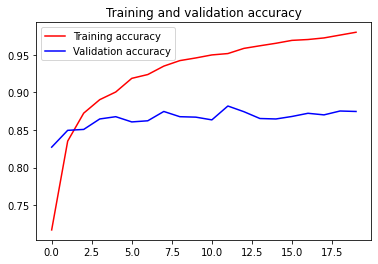

<Figure size 432x288 with 0 Axes>

In [ ]:
his = history_3
acc = his.history['accuracy']
val_acc = his.history['val_accuracy']
loss = his.history['loss']
val_loss = his.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### DenseNet v2

In [ ]:
old_model = tf.keras.applications.DenseNet121(weights = 'imagenet', include_top = False, input_shape = (64,64,3))
for layer in old_model.layers:
  layer.trainable = False
# for layer in old_model.layers[-4:]:
#   layer.trainable = True
model_3 = Sequential()
model_3.add(old_model)
model_3.add(tf.keras.layers.GlobalAveragePooling2D())
model_3.add(tf.keras.layers.Dense(15, activation = 'softmax'))
model_3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=20)

### VGG16 with image augmentation | Summary: Train: %; Val: %

In [10]:
VGG = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(64,64,3),
)
# VGG.summary()
for layer in VGG.layers:
  layer.trainable = False

model_vgg = Sequential()
model_vgg.add(VGG)
model_vgg.add(tf.keras.layers.Flatten())
# model_vgg.add(tf.keras.layers.Dense(64, activation = 'relu'))
model_vgg.add(tf.keras.layers.Dropout(0.2))
model_vgg.add(tf.keras.layers.Dense(15, activation = 'softmax'))

model_vgg.summary()
# optimizer1 = tf.keras.optimizers.SGD(lr=0.05, decay=0.1, momentum=0.1, nesterov=False)

# model_vgg.compile(optimizer= optimizer1, loss='categorical_crossentropy', metrics=['accuracy'])
# history_vgg = model_vgg.fit(X_train,Y_train, validation_data=(X_val, Y_val), batch_size = 50, epochs=20)

model_vgg.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
		zoom_range=0.2,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.2,
		horizontal_flip=True,
		fill_mode="nearest"
)
train_set = train_datagen.flow(X_train, y=Y_train)

history_vgg = model_vgg.fit(train_set, validation_data=(X_val, Y_val), epochs=30)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                30735     
Total params: 14,745,423
Trainable params: 30,735
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
370/413 [=========================>....] - ETA: 59s - loss: 1.6417 - accuracy: 0.4788 

KeyboardInterrupt: ignored